# **1. Problema**

Identificação de padrão de inadimplência sob base de dados de dados de conseção de crédito. *Default* = 1 (inadimplentes) alvo da análise.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# **2. Carregameneto de dados:**

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/develop/dataset/credito.csv', na_values='na')

df.head()

,id,default,idade,sexo,dependentes,escolaridade,estado_civil,salario_anual,tipo_cartao,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m
0,768805383,0,45,M,3,ensino medio,casado,$60K - $80K,blue,39,5,3,1,"12.691,51","1.144,90",42
1,818770008,0,49,F,5,mestrado,solteiro,menos que $40K,blue,44,6,2,1,"8.256,96","1.291,45",33
2,713982108,0,51,M,3,mestrado,casado,$80K - $120K,blue,36,4,0,1,"3.418,56","1.887,72",20
3,769911858,0,40,F,4,ensino medio,NaN,menos que $40K,blue,34,3,1,4,"3.313,03","1.171,56",20
4,709106358,0,40,M,3,sem educacao formal,casado,$60K - $80K,blue,21,5,0,1,"4.716,22","816,08",28


# **3. Exploração de dados:**

## *3.1 Massa bruta de dados*

**Métricas gerais da massa de dados para análise.**

In [ ]:
linhas, colunas = df.shape
print(f'A matriz de dados tem {linhas} linhas e {colunas} colunas.')

A matriz de dados tem 10127 linhas e 16 colunas.


In [ ]:
qtd_total, _ = df.shape
qtd_adimplentes, _ = df[df['default'] == 0].shape
qtd_inadimplentes, _ = df[df['default'] == 1].shape

print(f"A proporcão clientes adimplentes é de {round(100 * qtd_adimplentes / qtd_total, 2)}%")
print(f"A proporcão clientes inadimplentes é de {round(100 * qtd_inadimplentes / qtd_total, 2)}%")

A proporcão clientes adimplentes é de 83.93%
A proporcão clientes inadimplentes é de 16.07%


In [ ]:
df.select_dtypes('object').describe().transpose() # limite_credito e valor_transacoes_12m indevidamente classificados como string

,count,unique,top,freq
sexo,10127,2,F,5358
escolaridade,8608,5,mestrado,3128
estado_civil,9378,3,casado,4687
salario_anual,9015,5,menos que $40K,3561
tipo_cartao,10127,4,blue,9436
limite_credito,10127,9272,"1.438,21",11
valor_transacoes_12m,10127,10035,"3.851,51",3


In [ ]:
df.drop('id', axis=1).select_dtypes('number').describe().transpose() # métricas dos valores númericos (faltando os dois campos citados anteriormente)

,count,mean,std,min,25%,50%,75%,max
default,10127.0,0.160660,0.367235,0.0,0.0,0.0,0.0,1.0
idade,10127.0,46.325960,8.016814,26.0,41.0,46.0,52.0,73.0
dependentes,10127.0,2.346203,1.298908,0.0,1.0,2.0,3.0,5.0
meses_de_relacionamento,10127.0,35.928409,7.986416,13.0,31.0,36.0,40.0,56.0
qtd_produtos,10127.0,3.812580,1.554408,1.0,3.0,4.0,5.0,6.0
iteracoes_12m,10127.0,2.455317,1.106225,0.0,2.0,2.0,3.0,6.0
meses_inativo_12m,10127.0,2.341167,1.010622,0.0,2.0,2.0,3.0,6.0
qtd_transacoes_12m,10127.0,64.858695,23.472570,10.0,45.0,67.0,81.0,139.0


## *3.2 Tratando dados faltantes*

**Verificando o montante de dados faltantes que possam comprometer a leitura adequeda da amostra de dados.**

In [ ]:
df.isna().any() # identificação das colunas com dados faltantes

id                         False
default                    False
idade                      False
sexo                       False
dependentes                False
escolaridade                True
estado_civil                True
salario_anual               True
tipo_cartao                False
meses_de_relacionamento    False
qtd_produtos               False
iteracoes_12m              False
meses_inativo_12m          False
limite_credito             False
valor_transacoes_12m       False
qtd_transacoes_12m         False
dtype: bool

In [ ]:
def stats_dados_faltantes(df: pd.DataFrame) -> None:

  stats_dados_faltantes = []
  for col in df.columns:
    if df[col].isna().any():
      qtd, _ = df[df[col].isna()].shape
      total, _ = df.shape
      dict_dados_faltantes = {col: {'quantidade': qtd, "porcentagem": round(100 * qtd/total, 2)}}
      stats_dados_faltantes.append(dict_dados_faltantes)

  for stat in stats_dados_faltantes:
    print(stat)
  
print('\033[1m' + 'Dados faltantes base completa:' + '\033[0m')
stats_dados_faltantes(df=df) # mensuração da quantidade de dados faltantes

Dados faltantes base completa:
{'escolaridade': {'quantidade': 1519, 'porcentagem': 15.0}}
{'estado_civil': {'quantidade': 749, 'porcentagem': 7.4}}
{'salario_anual': {'quantidade': 1112, 'porcentagem': 10.98}}


In [ ]:
print('\033[1m' + 'Dados faltantes clientes adiplentes:' + '\033[0m')
stats_dados_faltantes(df=df[df['default'] == 0])

print('\n\033[1m' + 'Dados faltantes clientes inadiplentes:' + '\033[0m')
stats_dados_faltantes(df=df[df['default'] == 1])

Dados faltantes clientes adiplentes:
{'escolaridade': {'quantidade': 1263, 'porcentagem': 14.86}}
{'estado_civil': {'quantidade': 620, 'porcentagem': 7.29}}
{'salario_anual': {'quantidade': 925, 'porcentagem': 10.88}}

Dados faltantes clientes inadiplentes:
{'escolaridade': {'quantidade': 256, 'porcentagem': 15.73}}
{'estado_civil': {'quantidade': 129, 'porcentagem': 7.93}}
{'salario_anual': {'quantidade': 187, 'porcentagem': 11.49}}


# **4. Limpenza de dados**

**Conversão de string indevida em float e limpeza de dados vazios**

## *4.1 Correção dos valores*

**Uma vez identificadas as colunas que devem ser tratadas como números(float) fazemos a conversão dos dados.**

In [ ]:
df[['limite_credito', 'valor_transacoes_12m']].dtypes # antes da conversão para float


limite_credito          object
valor_transacoes_12m    object
dtype: object

In [ ]:
fn = lambda valor: float(valor.replace(".", "").replace(",", ".")) # teste de função para ajuste dos valores em float

valores_originais = ['12.691,51', '8.256,96', '3.418,56', '3.313,03', '4.716,22']
valores_limpos = list(map(fn, valores_originais))

print(valores_originais)
print(valores_limpos)

['12.691,51', '8.256,96', '3.418,56', '3.313,03', '4.716,22']
[12691.51, 8256.96, 3418.56, 3313.03, 4716.22]


In [ ]:
# aplicação do teste na base real
df['valor_transacoes_12m'] = df['valor_transacoes_12m'].apply(lambda valor: float(valor.replace(".", "").replace(",", ".")))
df['limite_credito'] = df['limite_credito'].apply(lambda valor: float(valor.replace(".", "").replace(",", ".")))

In [ ]:
df.drop('id', axis=1).select_dtypes('number').describe().transpose() # métricas corrigidas após ajuste dos floats

,count,mean,std,min,25%,50%,75%,max
default,10127.0,0.160660,0.367235,0.00,0.000,0.00,0.000,1.00
idade,10127.0,46.325960,8.016814,26.00,41.000,46.00,52.000,73.00
dependentes,10127.0,2.346203,1.298908,0.00,1.000,2.00,3.000,5.00
meses_de_relacionamento,10127.0,35.928409,7.986416,13.00,31.000,36.00,40.000,56.00
qtd_produtos,10127.0,3.812580,1.554408,1.00,3.000,4.00,5.000,6.00
iteracoes_12m,10127.0,2.455317,1.106225,0.00,2.000,2.00,3.000,6.00
meses_inativo_12m,10127.0,2.341167,1.010622,0.00,2.000,2.00,3.000,6.00
limite_credito,10127.0,8632.440165,9088.788041,1438.00,2555.355,4549.42,11068.175,34516.99
valor_transacoes_12m,10127.0,4404.583047,3397.128078,510.16,2155.825,3899.59,4741.310,18484.93
qtd_transacoes_12m,10127.0,64.858695,23.472570,10.00,45.000,67.00,81.000,139.00


In [ ]:
df.select_dtypes('object').describe().transpose()# métricas corrigidas após ajuste dos floats

,count,unique,top,freq
sexo,10127,2,F,5358
escolaridade,8608,5,mestrado,3128
estado_civil,9378,3,casado,4687
salario_anual,9015,5,menos que $40K,3561
tipo_cartao,10127,4,blue,9436


## *4.2 Limpeza de dados*

**Remoção das linhas de dados com valores vazios nas colunas.**

In [ ]:
df.dropna(inplace=True)

qtd_total_novo, _ = df.shape
qtd_adimplentes_novo, _ = df[df['default'] == 0].shape
qtd_inadimplentes_novo, _ = df[df['default'] == 1].shape

print(f"A proporcão anterior de adimplentes ativos é de {round(100 * qtd_adimplentes / qtd_total, 2)}%")
print(f"A nova proporcão de clientes adimplentes é de {round(100 * qtd_adimplentes_novo / qtd_total_novo, 2)}%")
print("")
print(f"A proporcão anterior de clientes inadimplentes é de {round(100 * qtd_inadimplentes / qtd_total, 2)}%")
print(f"A nova proporcão de clientes inadimplentes é de {round(100 * qtd_inadimplentes_novo / qtd_total_novo, 2)}%")

A proporcão anterior de adimplentes ativos é de 83.93%
A nova proporcão de clientes adimplentes é de 84.28%

A proporcão anterior de clientes inadimplentes é de 16.07%
A nova proporcão de clientes inadimplentes é de 15.72%


# **5. Análise de dados**

## 5.1 Análise por categorias

A primeira análise baseada nas categorias para descobrir possível relação com os eventos alvo do default.
Classes analisadas: *escolaridade, salário anual e estado civil.*

In [ ]:
df.select_dtypes('object').head(n=5)

,sexo,escolaridade,estado_civil,salario_anual,tipo_cartao
0,M,ensino medio,casado,$60K - $80K,blue
1,F,mestrado,solteiro,menos que $40K,blue
2,M,mestrado,casado,$80K - $120K,blue
4,M,sem educacao formal,casado,$60K - $80K,blue
5,M,mestrado,casado,$40K - $60K,blue


In [ ]:
sns.set_style("whitegrid")

df_adimplente = df[df['default'] == 0]
df_inadimplente = df[df['default'] == 1]

In [ ]:
def categoria_graficos (coluna: str, titulos: list): # função gera sequência de subplots por categoria

  eixo = 0
  max_y = 0
  max = df.select_dtypes('object').describe()[coluna]['freq'] * 1.1

  figura, eixos = plt.subplots(1,3, figsize=(20, 5), sharex=True)

  for dataframe in [df, df_adimplente, df_inadimplente]:

    df_to_plot = dataframe[coluna].value_counts().to_frame()
    df_to_plot.rename(columns={coluna: 'frequencia_absoluta'}, inplace=True)
    df_to_plot[coluna] = df_to_plot.index
    df_to_plot.sort_values(by=[coluna], inplace=True)
    df_to_plot.sort_values(by=[coluna])

    f = sns.barplot(x=df_to_plot[coluna], y=df_to_plot['frequencia_absoluta'], ax=eixos[eixo])
    f.set(title=titulos[eixo], xlabel=coluna.capitalize(), ylabel='Frequência Absoluta')
    f.set_xticklabels(labels=f.get_xticklabels(), rotation=90)

    _, max_y_f = f.get_ylim()
    max_y = max_y_f if max_y_f > max_y else max_y
    f.set(ylim=(0, max_y))

    eixo += 1

  return figura

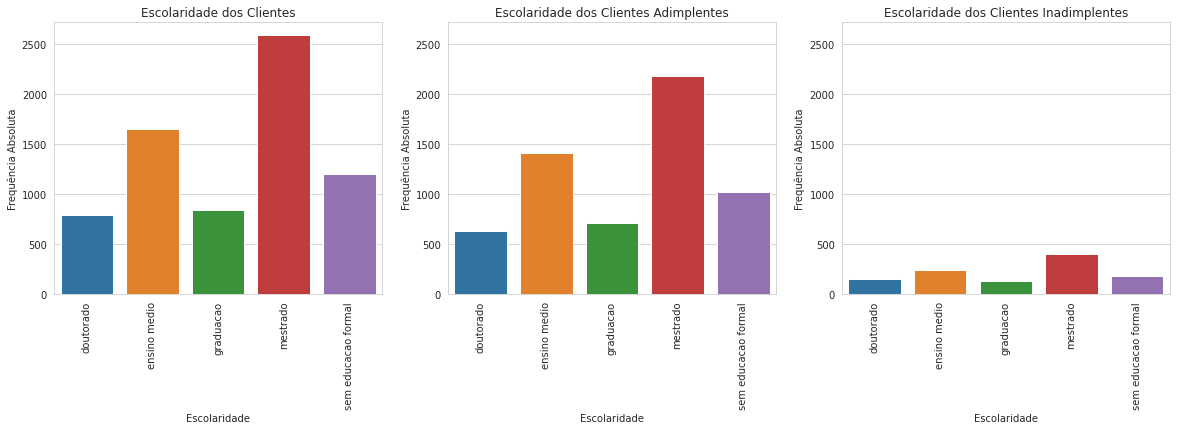

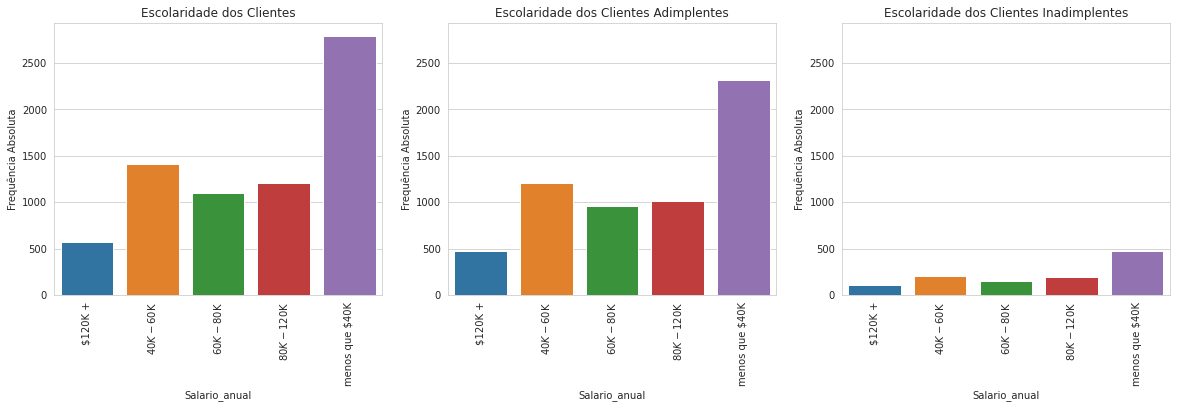

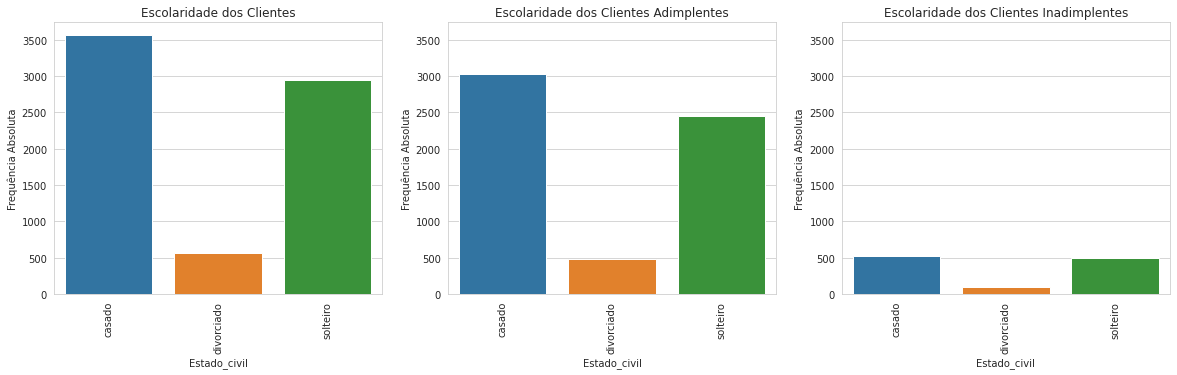

In [ ]:
colunas = ['escolaridade', 'salario_anual', 'estado_civil']
titulos = ['Escolaridade dos Clientes', 'Escolaridade dos Clientes Adimplentes', 'Escolaridade dos Clientes Inadimplentes']

figura = plt

for coluna in colunas:
  figura.show(categoria_graficos(coluna, titulos))

## 5.2 Análise numérica

Análise das variáveis númericas da amostra. Variáveis analisadas: *quantidade de transações nos últimos 12 meses e valor das transações dos últimos 12 meses.*

In [ ]:
df.drop(['id', 'default'], axis=1).select_dtypes('number').head(n=5)

,idade,dependentes,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m
0,45,3,39,5,3,1,12691.51,1144.90,42
1,49,5,44,6,2,1,8256.96,1291.45,33
2,51,3,36,4,0,1,3418.56,1887.72,20
4,40,3,21,5,0,1,4716.22,816.08,28
5,44,2,36,3,2,1,4010.69,1088.07,24


In [ ]:
def variaveis_graficos (coluna: str, titulos: list): # função gera sequência de subplots por categoria

  eixo = 0
  max_y = 0
  figura, eixos = plt.subplots(1,3, figsize=(20, 5), sharex=True)

  for dataframe in [df, df_adimplente, df_inadimplente]:

    f = sns.histplot(x=coluna, data=dataframe, stat='count', ax=eixos[eixo])
    f.set(title=titulos[eixo], xlabel=coluna.capitalize(), ylabel='Frequência Absoluta')

    _, max_y_f = f.get_ylim()
    max_y = max_y_f if max_y_f > max_y else max_y
    f.set(ylim=(0, max_y))

    eixo += 1
  
  return figura


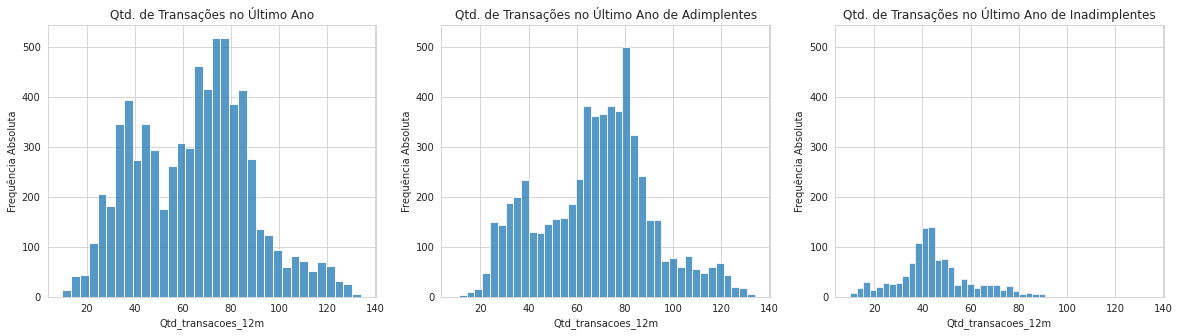

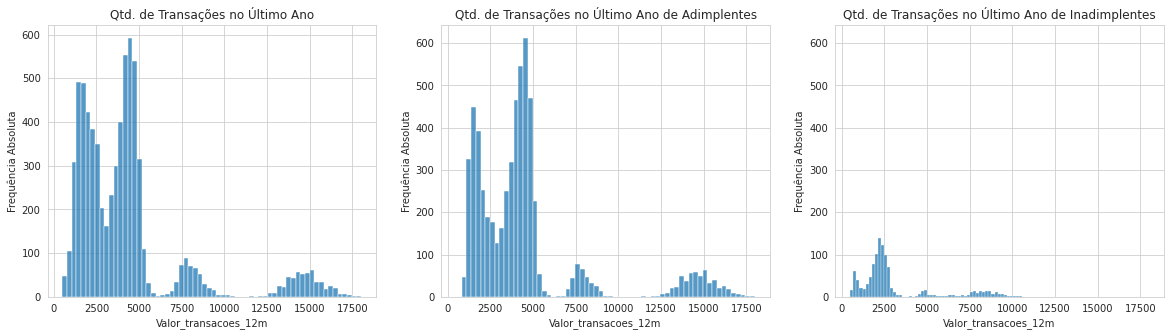

In [ ]:
colunas = ['qtd_transacoes_12m', 'valor_transacoes_12m']
titulos = ['Qtd. de Transações no Último Ano', 'Qtd. de Transações no Último Ano de Adimplentes', 'Qtd. de Transações no Último Ano de Inadimplentes']

for coluna in colunas:
  figura.show(variaveis_graficos(coluna, titulos))

Com base no resultado dos histogramas das duas variáveis estudadas temos abaixo a relação entre ambas no gráfico de relacionamento.

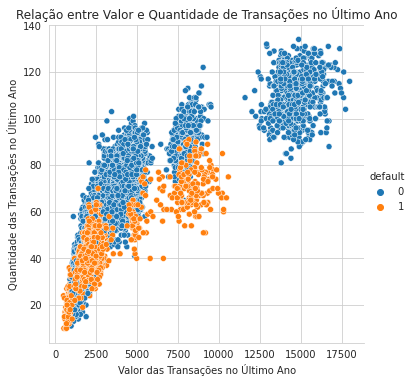

In [ ]:
f = sns.relplot(x='valor_transacoes_12m', y='qtd_transacoes_12m', data=df, hue='default')
_ = f.set(
    title='Relação entre Valor e Quantidade de Transações no Último Ano', 
    xlabel='Valor das Transações no Último Ano', 
    ylabel='Quantidade das Transações no Último Ano'
  )

# **6. Insigths**

## 6.1 Dados descartados

O percentual de dados vazios que foram descartados da amostra não compromete a validade da massa de dados, pois a proporção entre clientes adiplentes e inadimplentes se manteve praticamente a mesma.

## 6.2 Análise com base nas categorias

O que ficou claro na análise gráfica dos dados com base nas categorias escolaridade, estado civil e salario anual e que essas características não explicam maior ou menor índice de inandimplência. As proporções entre default e não default com relação a massa total se mantem praticamente iguais. Ou seja, não sinalizam nenhuma distorção que explique a inadimplência. 

## 6.3 Análise com base nas variáveis numéricas

Já com relação a análise dos gráficos das variáveis quantidade de transações em 12 meses e valor das transações em 12 meses é possível perceber que existe um comportamento anômalo para uma faixa específica de valor de transações e quantidade de transações.

Existe um forte incremento de clientes inadimplentes na faixa entre 35 e 45 transações anuais e na faixa média de valor de transações em R$ 2.500,00.

Quando sobrepomos as duas amostras no gráfico de relacionamento fica ainda mais claro a existência de uma relação entre o número de transações na faixa 35-45 com os valores médios de R$ 2.500,00, indicando uma atenção especial para esse grupo de clientes.

